In [1]:
import tensorflow as tf
import numpy as np
import gym
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque

Using TensorFlow backend.


In [2]:
env = gym.make('CartPole-v0')

[2017-07-11 23:09:36,751] Making new env: CartPole-v0


In [4]:
state = env.reset()
for i in range(500):
    next_state, reward, done, _ = env.step(env.action_space.sample())
    # print(reward)
    if done:
        print(i)
        break

10


In [42]:
lr = 0.001
mem_size = 2000
episodes = 2000
steps = 1000

epsilon = 1
epsilon_min = 0.01
epsilon_decay = 0.0001

gamma = 0.99
batch_size = 32

In [43]:
bot = Sequential()
bot.add(Dense(units=24, input_dim=4, activation='relu'))
bot.add(Dense(units=24, activation='relu'))
bot.add(Dense(units=2, activation='linear'))
bot.compile(loss='mse', optimizer=Adam(lr))

memory = deque(maxlen=mem_size)

In [44]:
env.reset()
state, reward, done, _ = env.step(env.action_space.sample())
for i in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    
    if done:
        next_state = np.zeros(state.shape)
        memory.append((state, action, next_state, reward, done))
        env.reset()
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        memory.append((state, action, next_state, reward, done))
        state = next_state
len(memory)

32

In [46]:
reward_list = []
step = 0
for episode in range(episodes):
    state = env.reset()
    total_rewards = 0
    t = 0 
    while t < steps:
        step = step + 1
        explore = epsilon_min + (epsilon - epsilon_min) * np.exp(-epsilon_decay * step)
        if explore >= np.random.rand():
            action = env.action_space.sample()
        else:
            action = np.argmax(bot.predict(np.reshape(state, (1, 4))))
        next_state, reward, done, _ = env.step(action)
        total_rewards = total_rewards + reward
        # reward = reward if not done else -10
        if done:
            reward_list.append(total_rewards)
            next_state = np.zeros(state.shape)
            memory.append((state, action, next_state, reward, done))
            print('episode:{} steps:{} rewards:{} explore:{}'.format(episode + 1, t + 1, total_rewards, explore))
            env.reset()
            state, reward, done, _ = env.step(env.action_space.sample())
            t = steps
        else:
            memory.append((state, action, next_state, reward, done))
            state = next_state
            t = t+1
            
    
        minibatch = [memory[ii] for ii in np.random.choice(range(len(memory)), batch_size)]
        states = [each[0] for each in minibatch]
        actions = [each[1] for each in minibatch]
        next_states = [each[2] for each in minibatch]
        rewards = [each[3] for each in minibatch]
        dones = [each[4] for each in minibatch]
        
        next_states = np.reshape(next_states, (-1, 4))
        states = np.reshape(states, (-1, 4))
        actions = np.reshape(actions, (batch_size, 1))
        targetQs = bot.predict(next_states)
        episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
        targetQs[episode_ends] = (0, 0)
        
        targets = rewards + gamma * np.max(targetQs, axis=1)
        targets_f = bot.predict(states)
        
        for pos in range(len(actions)):
            targets_f[pos,actions[pos]] = targets[pos]
        
        bot.fit(states, targets_f, epochs=1, verbose=0)

episode:1 steps:10 rewards:10.0 explore:0.9990104948350412
episode:2 steps:12 rewards:12.0 explore:0.9978243940440459
episode:3 steps:10 rewards:10.0 explore:0.9968370633976026
episode:4 steps:12 rewards:12.0 explore:0.9956535691600873
episode:5 steps:16 rewards:16.0 explore:0.9940777844133959
episode:6 steps:23 rewards:23.0 explore:0.991817006400586
episode:7 steps:21 rewards:21.0 explore:0.9897573540790046
episode:8 steps:10 rewards:10.0 explore:0.9887780864403506
episode:9 steps:17 rewards:17.0 explore:0.9871155772266214
episode:10 steps:14 rewards:14.0 explore:0.9857485725450585
episode:11 steps:12 rewards:12.0 explore:0.9845783765160454
episode:12 steps:25 rewards:25.0 explore:0.9821449735958028
episode:13 steps:13 rewards:13.0 explore:0.9808820062367796
episode:14 steps:15 rewards:15.0 explore:0.979426774923765
episode:15 steps:13 rewards:13.0 explore:0.9781673389271324
episode:16 steps:35 rewards:35.0 explore:0.9747846763535254
episode:17 steps:16 rewards:16.0 explore:0.97324225

KeyboardInterrupt: 

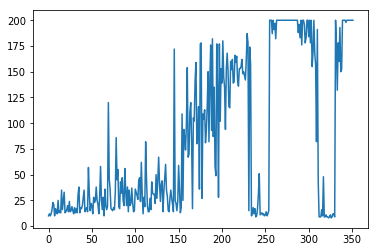

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(reward_list)